# Project 1: Similarity Analysis of Philosophers' Thoughts

##### by Jiajun Du

## 1. Introduction

Hegel once said: Existence is rationality, and rationality must also exist. Then we need to analyze some of the words published by these philosophers and what they said. In philosophy, countless famous philosophers have emerged in the long history of the past. Among them are the familiar Aristotle, Plato, Hegel, and many more. In this analysis, I intend to analyze the similarity of the statements of these authors. First, we will analyze which titles have more paragraphs, which authors have more paragraphs, which times have more titles, and which genres have more paragraphs. Secondly, I selected three of the most well-known philosophers to make a word cloud map of their passages and observed and found whether their high-frequency speeches were similar. Finally, using TD-IDF to calculate the similarity is to look at the similarity of the text between titles (that is, the philosophical arguments reflected by this title). Typically, each philosopher's thinking differs from his title (book or paper). Therefore, the similarity is very high. Here we want to see if there are similarities between the ideas and arguments of different philosophers, that is to say, two authors correspond to two books, and it turns out that the two books have a high degree of similarity, that is, Isn't it possible to explain that the two authors' philosophical thoughts are similar? Among them, we chose the three writers who quoted the most speeches, Aristotle, Plato, and Hegel.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim import  corpora,models, similarities
import codecs

## 2. Read Dataset

First we are going to read the dataset and view data dimensions, (rows, columns).

In [2]:
data = pd.read_csv('philosophy_data.csv')
data.shape

(360808, 11)

Let's look at the first few rows of the data.

In [3]:
data.head(3)

,title,author,school,sentence_spacy,sentence_str,original_publication_date,corpus_edition_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...","What's new, Socrates, to make you leave your ...",-350,1997,125,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea..."
1,Plato - Complete Works,Plato,plato,Surely you are not prosecuting anyone before t...,Surely you are not prosecuting anyone before t...,-350,1997,69,surely you are not prosecuting anyone before t...,"['surely', 'you', 'are', 'not', 'prosecuting',...",surely -PRON- be not prosecute anyone before ...
2,Plato - Complete Works,Plato,plato,The Athenians do not call this a prosecution b...,The Athenians do not call this a prosecution b...,-350,1997,74,the athenians do not call this a prosecution b...,"['the', 'athenians', 'do', 'not', 'call', 'thi...",the Athenians do not call this a prosecution ...


## 3. Data Summary

First of all, we are going to analyze title, author, school, corpus_edition_date.

### 3.1 Title

In [4]:
title_count = (data
               .groupby('title', as_index=False)
               .author
               .count()
               .rename(columns={'author':'title_cnt'})
               .sort_values('title_cnt', ascending=False))

Through data analysis, we get a total of 52 titles, the most cited are Aristotle - Complete Works and Plato - Complete Works with 48779 and 38366 titles respectively.

In [5]:
print(title_count.shape)
title_count.head()

(59, 2)


,title,title_cnt
4,Aristotle - Complete Works,48779
32,Plato - Complete Works,38366
21,Lewis - Papers,13120
48,The Second Sex,13017
47,The Search After Truth,12997


We extracted the top 20 titles and observed them. We found that Aristotle - Complete Works, Plato - Complete Works appeared a lot.

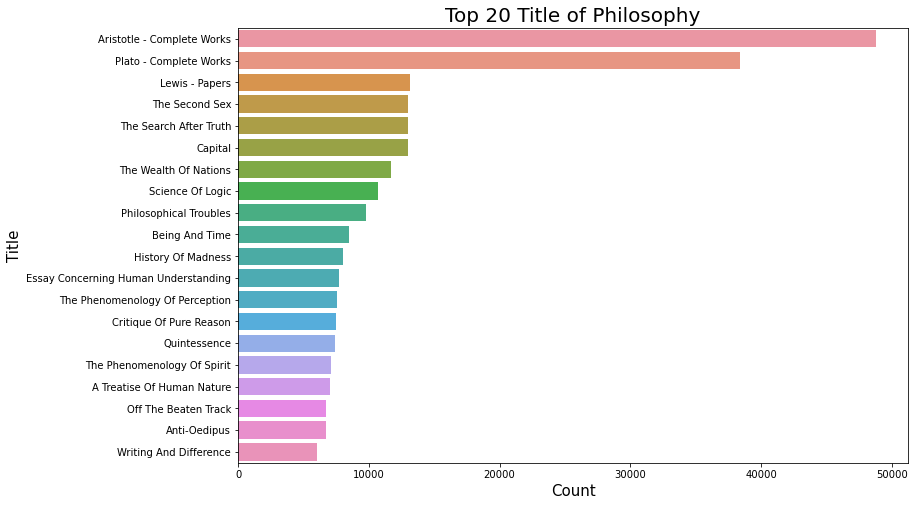

In [6]:
plt.figure(figsize=(12,8))
sns.barplot(data=title_count[:20],x='title_cnt',y='title')
plt.xlabel('Count',size=15)
plt.ylabel('Title',size=15)
plt.title('Top 20 Title of Philosophy', size=20)
plt.show()

### 3.2 Author

Using the same method, let's see which authors have more ideas.

In [7]:
author_count = (data
                .groupby('author', as_index=False)
                .agg(cnt = ('title', 'count'),
                     title_cnt = ('title', 'nunique'),
                     school_cnt = ('school', 'nunique'))
                .sort_values('cnt', ascending=False)
                .reset_index(drop=1))

From this we found a total of 36 writers who appeared frequently in this analysis.

In [8]:
print(author_count.shape)
author_count.head()

(36, 4)


,author,cnt,title_cnt,school_cnt
0,Aristotle,48779,1,1
1,Plato,38366,1,1
2,Hegel,22700,3,1
3,Foucault,15240,3,1
4,Heidegger,15239,2,1


Through analysis, we found that Aristotle, Plato, Hegel have more quotes.

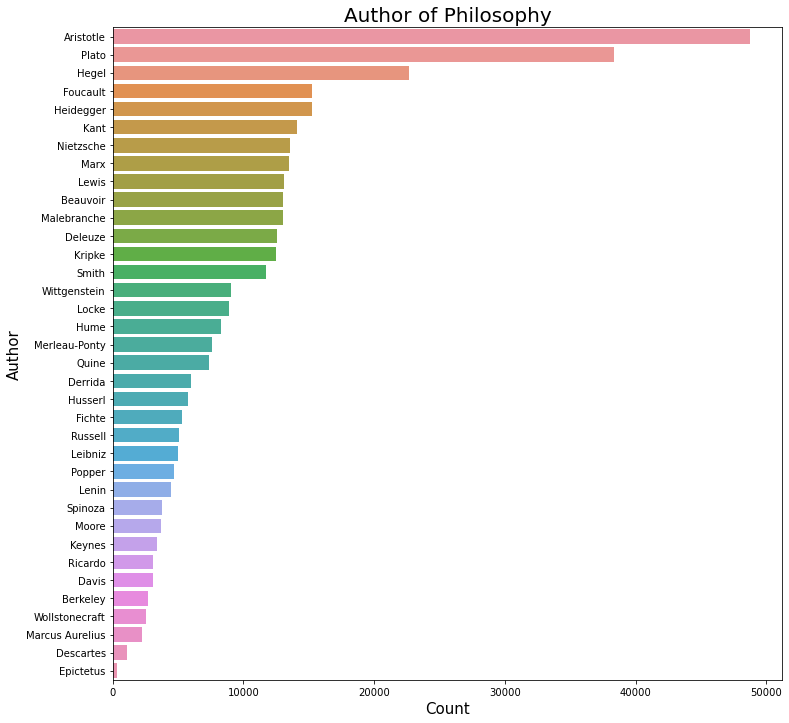

In [9]:
plt.figure(figsize=(12,12))
sns.barplot(data=author_count,x='cnt',y='author')
plt.xlabel('Count',size=15)
plt.ylabel('Author',size=15)
plt.title('Author of Philosophy', size=20)
plt.show()

### 3.3 School

In [10]:
school_count = (data
                .groupby('school', as_index=False)
                .agg(cnt = ('title', 'count'),
                     title_cnt = ('title', 'nunique'),
                     author_cnt = ('author', 'nunique'))
                .sort_values('cnt', ascending=False)
                .reset_index(drop=1))

We found a total of 13 disciplines.

In [11]:
print(school_count.shape)
school_count.head()

(13, 4)


,school,cnt,title_cnt,author_cnt
0,analytic,55425,11,7
1,aristotle,48779,1,1
2,german_idealism,42136,7,3
3,plato,38366,1,1
4,continental,33779,6,3


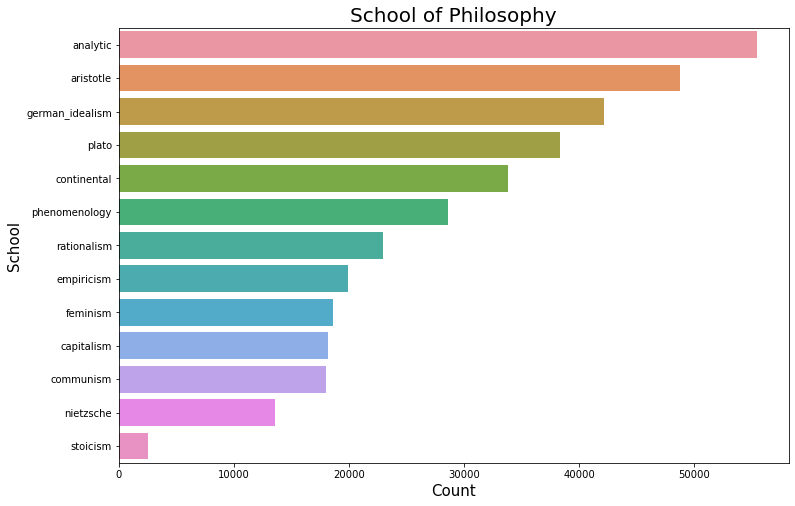

In [12]:
plt.figure(figsize=(12,8))
sns.barplot(data=school_count,x='cnt',y='school')
plt.xlabel('Count',size=15)
plt.ylabel('School',size=15)
plt.title('School of Philosophy', size=20)
plt.show()

### 3.4 Corpus Edition Date

In [13]:
date_count = (data
              .groupby('corpus_edition_date', as_index=False)
              .agg(cnt = ('title', 'count'),
                   title_cnt = ('title', 'nunique'))
              .sort_values('corpus_edition_date')
              .reset_index(drop=1))

We found a total of 28 years.

In [14]:
print(date_count.shape)
date_count.head()

(28, 3)


,corpus_edition_date,cnt,title_cnt
0,1887,12996,1
1,1966,4469,1
2,1969,1984,1
3,1970,5325,2
4,1977,7099,1


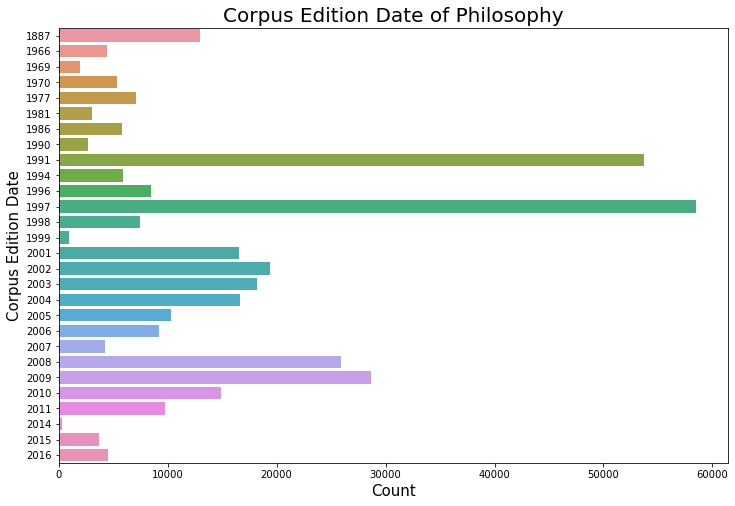

In [15]:
date_count.corpus_edition_date = date_count.corpus_edition_date.astype('str')
plt.figure(figsize=(12,8))
sns.barplot(data=date_count,x='cnt',y='corpus_edition_date')
plt.ylabel('Corpus Edition Date',size=15)
plt.xlabel('Count',size=15)
plt.title('Corpus Edition Date of Philosophy', size=20)
plt.show()

By comparing the picture above, it can be judged that the quoted speeches are relatively early, but the book production is relatively low, and the number of books is small. The number of recent books is large, but the quoted speeches are less.

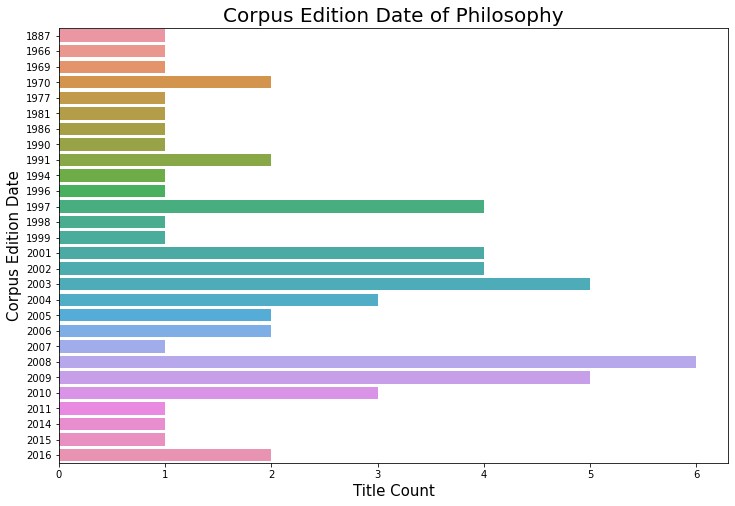

In [16]:
plt.figure(figsize=(12,8))
sns.barplot(data=date_count,x='title_cnt',y='corpus_edition_date')
plt.ylabel('Corpus Edition Date',size=15)
plt.xlabel('Title Count',size=15)
plt.title('Corpus Edition Date of Philosophy', size=20)
plt.show()

## 4. Word Cloud

We choose the 3 writers Aristotle, Plato and Hegel who quote the most speeches, and then observe which words appear more in their speeches.

In [17]:
stop = set(STOPWORDS)

In [18]:
data.head(5)

,title,author,school,sentence_spacy,sentence_str,original_publication_date,corpus_edition_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...","What's new, Socrates, to make you leave your ...",-350,1997,125,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea..."
1,Plato - Complete Works,Plato,plato,Surely you are not prosecuting anyone before t...,Surely you are not prosecuting anyone before t...,-350,1997,69,surely you are not prosecuting anyone before t...,"['surely', 'you', 'are', 'not', 'prosecuting',...",surely -PRON- be not prosecute anyone before ...
2,Plato - Complete Works,Plato,plato,The Athenians do not call this a prosecution b...,The Athenians do not call this a prosecution b...,-350,1997,74,the athenians do not call this a prosecution b...,"['the', 'athenians', 'do', 'not', 'call', 'thi...",the Athenians do not call this a prosecution ...
3,Plato - Complete Works,Plato,plato,What is this you say?,What is this you say?,-350,1997,21,what is this you say?,"['what', 'is', 'this', 'you', 'say']",what be this -PRON- say ?
4,Plato - Complete Works,Plato,plato,"Someone must have indicted you, for you are no...","Someone must have indicted you, for you are no...",-350,1997,101,"someone must have indicted you, for you are no...","['someone', 'must', 'have', 'indicted', 'you',...","someone must have indict -PRON- , for -PRON- ..."


In [19]:
data['tokenized'] = data['tokenized_txt'].apply(lambda x: x.replace('[', '').replace(']',''))

In [20]:
author_list = set(data['author'])
author_words_dict = {}
for aut in author_list:
    save_list = []
    tmp = data[data['author'] == aut]['tokenized'].tolist()
    # print(aut)
    for i in tmp:
        if i != '':
            save_list.extend(eval(i))
    
    author_words_dict[aut] = save_list

In [21]:
# We count the number of occurrences of each character in each string
def count_char(s):
    char_dict = {}
    for i in s:
        if i not in char_dict:
            char_dict[i] = 1
        else:
            char_dict[i] += 1
    
    return char_dict

Through analysis, we found that there are some useless words, because there are some useless words, so we need to filter out unimportant and unhelpful words, and store each author's words in the form of a dictionary in author_dict_v2
For the three authors we focus on 'Aristotle', 'Plato', 'Hegel' we choose to print out the top 20 high-frequency words,
There are many socrates in Plato, because Plato is a student of Socrates, and there are still many "meaningless" words in high-frequency words, such as 'will', 'said', 'make', 'don'
There are more adjectives and theoretical concept words such as consciousness, concept, existence, and universal in Hegel
Appears in Aristotle Nature, human body, man, animals are more
From a preliminary look, we found that the high-frequency words of the three people are different.

In [22]:
author_dict_v2 = {}
for aut in author_list:
    author_dict_v2[aut] = {k: v for k, v in count_char(author_words_dict[aut]).items() if k not in STOPWORDS}
    
    if aut in ['Aristotle', 'Plato', 'Hegel']:
        print(aut,'top 20 key words: ')
        print(sorted(author_dict_v2[aut].items(), key=lambda x: x[1], reverse=True)[:20])
        print()

Plato top 20 key words: 
[('one', 5084), ('will', 3047), ('things', 2930), ('say', 2672), ('now', 2447), ('said', 2331), ('must', 2272), ('good', 2263), ('man', 2179), ('think', 2177), ('us', 2047), ('well', 1983), ('way', 1926), ('socrates', 1866), ('people', 1725), ('thing', 1683), ('know', 1495), ('don', 1301), ('make', 1293), ('something', 1291)]

Aristotle top 20 key words: 
[('one', 9543), ('will', 5432), ('must', 4482), ('things', 4461), ('man', 4125), ('thing', 2905), ('good', 2627), ('animals', 2508), ('may', 2448), ('another', 2393), ('time', 2379), ('case', 2305), ('now', 2304), ('two', 2296), ('either', 2259), ('part', 2154), ('body', 2058), ('first', 2054), ('say', 2048), ('nature', 2047)]

Hegel top 20 key words: 
[('one', 3273), ('self', 3241), ('consciousness', 2496), ('concept', 1995), ('form', 1803), ('existence', 1773), ('content', 1682), ('first', 1631), ('universal', 1602), ('something', 1527), ('determination', 1514), ('unity', 1477), ('thus', 1349), ('determinate

It can also be shown from the data set that these three people belong to different philosophical schools.

In [23]:
data[data['author'].isin(['Aristotle', 'Plato', 'Hegel'])].groupby('author', as_index=False).school.agg(['nunique', 'max']).reset_index()

,author,nunique,max
0,Aristotle,1,aristotle
1,Hegel,1,german_idealism
2,Plato,1,plato


In [24]:
# Let's define a function to calculate the word cloud of an author
def auther_word_cloud(df, auther, stop_words, color='white'):

    df_filter = df[df['author'] == auther]
    words = ' '.join(word for word in df_filter.sentence_lowered.tolist())
    wordcloud = WordCloud(stopwords = stop_words,
                          max_font_size = 150,
                          min_font_size = 10,
                          max_words = 5000,
                          width = 800,
                          height = 600,
                          background_color = color).generate(words)
    
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

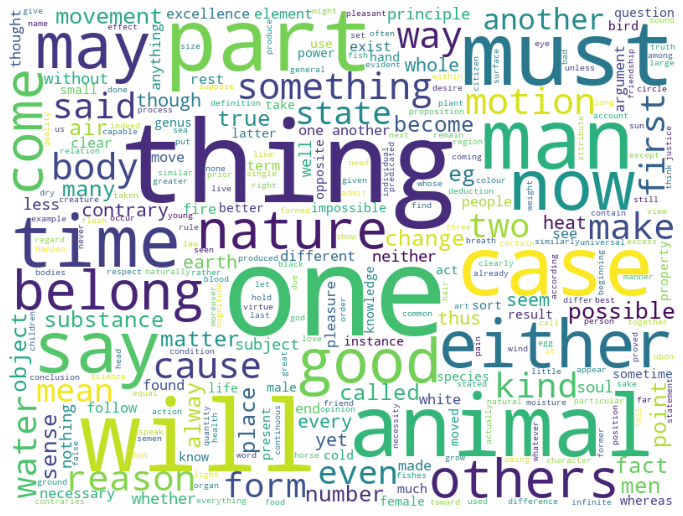

In [25]:
auther_word_cloud(df=data, auther='Aristotle',stop_words=STOPWORDS)

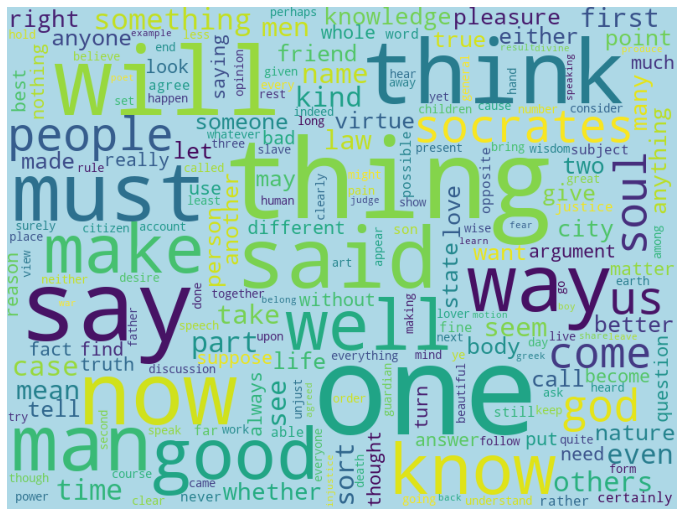

In [26]:
auther_word_cloud(df=data, auther='Plato',stop_words=STOPWORDS, color='lightblue')

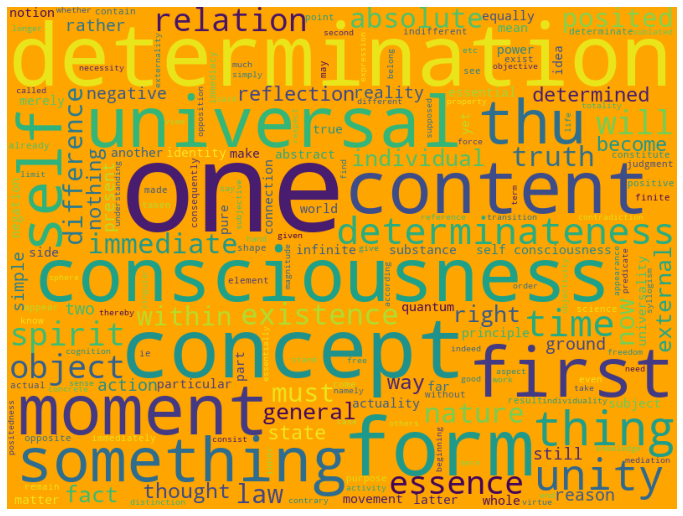

In [27]:
auther_word_cloud(df=data, auther='Hegel',stop_words=STOPWORDS, color='orange')

## 5. Text similarity

Follow the title dimension. We summarize the speeches, and we want to look for similarities between different titles, so as to find out whether there are certain similarities between scholars of different schools of thought.

In [28]:
title_set = set(data['title'])

In [29]:
title_words_dict = {}
for tit in title_set:
    save_list = []
    tmp = data[data['title'] == tit]['tokenized'].tolist()
    for i in tmp:
        if i != '':
            save_list.extend(eval(i))
    
    title_words_dict[tit] = save_list

In [30]:
# filter stop words
title_dict_v2 = {}
for tit in title_set:
    title_dict_v2[tit] = [word for word in title_words_dict[tit] if word not in STOPWORDS]

In [31]:
corpus = []
for k, v in title_dict_v2.items():
    corpus.append(v)

Build a bag of words model.

In [32]:
dictionary = corpora.Dictionary(corpus)

In [33]:
doc_vectors = [dictionary.doc2bow(text) for text in corpus]

The number of documents is 59 titles

In [34]:
print (dictionary.num_docs)

59


All word counts after stop word filtering.

In [35]:
print(dictionary.num_pos)

4317057


In [36]:
tfidf = models.TfidfModel(doc_vectors)

In [37]:
tfidf_vectors = tfidf[doc_vectors]

In [38]:
print(len(tfidf_vectors))
print(len(tfidf_vectors[0]))

59
4098


In [39]:
def TF_IDF(tfidf_vectors,doc_vectors):
    index = similarities.MatrixSimilarity(tfidf_vectors)
    # sims = index[doc_vectors[i]]
    return list(index)

In [40]:
sims = TF_IDF(tfidf_vectors,doc_vectors)

In [41]:
sim_df = pd.DataFrame()
for i in sims:
    tmp = pd.DataFrame(i)
    sim_df = pd.concat([sim_df, tmp], axis = 1)

In [42]:
data.columns

Index(['title', 'author', 'school', 'sentence_spacy', 'sentence_str',
       'original_publication_date', 'corpus_edition_date', 'sentence_length',
       'sentence_lowered', 'tokenized_txt', 'lemmatized_str', 'tokenized'],
      dtype='object')

In [43]:
author_info = data[['title','author','school']].drop_duplicates().reset_index(drop=True)

In [44]:
author_mapping = {k:v for k, v in zip(author_info.title, author_info.author)}

In [45]:
Plato_title = [k for k, v in author_mapping.items() if v == 'Plato']
Aristotle_title = [k for k, v in author_mapping.items() if v == 'Aristotle']
Hegel_title = [k for k, v in author_mapping.items() if v == 'Hegel']

In [46]:
Plato_title

['Plato - Complete Works']

In [47]:
Aristotle_title

['Aristotle - Complete Works']

In [48]:
Hegel_title

['Science Of Logic',
 'The Phenomenology Of Spirit',
 'Elements Of The Philosophy Of Right']

We find the title corresponding to 'Aristotle', 'Plato', 'Hegel'

In [49]:
for i, v in enumerate(title_set):
    if v in Plato_title:
        print(i, 'Plato: ', v)
    elif v in Aristotle_title:
        print(i, 'Aristotle: ', v)
    elif v in Hegel_title:
        print(i, 'Hegel: ', v)

11 Hegel:  Elements Of The Philosophy Of Right
20 Aristotle:  Aristotle - Complete Works
23 Hegel:  The Phenomenology Of Spirit
26 Plato:  Plato - Complete Works
46 Hegel:  Science Of Logic


In [50]:
sim_df.columns = title_set

- For Hegel, there are three titles, namely 'Elements Of The Philosophy Of Right', 'Science Of Logic', 'The Phenomenology Of Spirit'
- Not surprisingly, we observed that the similarity between the three books of Hegel is the highest, and each of the books in the remaining 58 books, Hegel's own thoughts seem to be self-contained
- The System Of Ethics book bears some resemblance to Hegel's book

In [51]:
sim_df.iloc[19].sort_values(ascending=False)[:5]

The Analysis Of Mind               1.000000
The Phenomenology Of Perception    0.174428
The Problems Of Philosophy         0.142037
Philosophical Investigations       0.121110
Philosophical Studies              0.113544
Name: 19, dtype: float32

In [52]:
sim_df.iloc[27].sort_values(ascending=False)[:5]

Vindication Of The Rights Of Woman    1.000000
The Second Sex                        0.447222
Women, Race, And Class                0.349506
Beyond Good And Evil                  0.199259
A Treatise Of Human Nature            0.150597
Name: 27, dtype: float32

In [53]:
sim_df.iloc[46].sort_values(ascending=False)[:5]

Science Of Logic                       1.000000
The Phenomenology Of Spirit            0.355822
Elements Of The Philosophy Of Right    0.168210
The System Of Ethics                   0.157998
Critique Of Pure Reason                0.141914
Name: 46, dtype: float32

- 'The System Of Ethics' by Fichte is from the same school as Hegel

In [54]:
author_info[author_info['title'].isin(['Elements Of The Philosophy Of Right', 'The System Of Ethics'])]

,title,author,school
39,The System Of Ethics,Fichte,german_idealism
42,Elements Of The Philosophy Of Right,Hegel,german_idealism


- For Aristotle, the closest parallel to him is Plato, who was Aristotle's teacher
- On the whole Aristotle's writings are in a class of their own, unlike other scholars, nor do they resemble the philosophy of his teachers

In [55]:
sim_df.iloc[39].sort_values(ascending=False)[:5]

Three Dialogues                                            1.000000
A Treatise Concerning The Principles Of Human Knowledge    0.350061
Essay Concerning Human Understanding                       0.234839
Dialogues Concerning Natural Religion                      0.113652
Meditations                                                0.103982
Name: 39, dtype: float32

In [56]:
author_info[author_info['title'].isin(['Aristotle - Complete Works', 'Plato - Complete Works', 'The Second Sex', 'Essay Concerning Human Understanding', 'Vindication Of The Rights Of Woman'])]

,title,author,school
0,Plato - Complete Works,Plato,plato
1,Aristotle - Complete Works,Aristotle,aristotle
3,Essay Concerning Human Understanding,Locke,empiricism
56,Vindication Of The Rights Of Woman,Wollstonecraft,feminism
57,The Second Sex,Beauvoir,feminism


- For Plato, Wittgenstein has some similarities
- Similar to Aristotle, Plato is in a class of its own

In [57]:
sim_df.iloc[47].sort_values(ascending=False)[:5]

A Treatise Of Human Nature                                 1.000000
Essay Concerning Human Understanding                       0.231751
A Treatise Concerning The Principles Of Human Knowledge    0.219444
Dialogues Concerning Natural Religion                      0.197809
The Search After Truth                                     0.159949
Name: 47, dtype: float32

In [58]:
author_info[author_info['title'].isin(['Plato - Complete Works', 'On Certainty', 'Philosophical Investigations', 'The Second Sex'])]

,title,author,school
0,Plato - Complete Works,Plato,plato
17,Philosophical Investigations,Wittgenstein,analytic
24,On Certainty,Wittgenstein,analytic
57,The Second Sex,Beauvoir,feminism


## 6. Conclusion

We selected the works of the three most influential scholars for text similarity analysis, and got the following conclusions
- Hegel, Aristotle, and Plato's ideological works are basically unique, and they are not very similar to other philosophers
- Especially the teacher-student relationship between Plato and Aristotle, but in terms of academic thinking, one is idealism and the other is materialism, and the philosophical concepts are very different
- Secondly, the high similarity of Hegel's three works shows that Hegel has a philosophical system, which also confirms our previous guess.
- The author of 'The System Of Ethics' is Fichte and Hegel have similar ideas, both from the same school.